# Validation of Library Strategy

Here I am looking to see how bad, and if I can improve, library strategy metadata.

In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook()

# Connect to data store
store = pd.HDFStore('../output/sra.h5', mode='r')

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2018-08-15 
Git hash: 3e6018d790e56d8ccd70647a7eccff8c120a8e6d


In [3]:
from pymongo import MongoClient
try:
    with open('../output/.mongodb_host', 'r') as fh:
        host = fh.read().strip()
except FileNotFoundError:
    host = 'localhost'

mongoClient = MongoClient(host=host, port=27017)
db = mongoClient['sra']
ncbi = db['ncbi']

In [4]:
srx_complete = store['aln/complete'].srx.unique().tolist()

In [5]:
lib_strat = pd.DataFrame(list(ncbi.aggregate([
    {
        '$match': {
            '_id': {'$in': srx_complete}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'library_strategy': '$sra.experiment.library_strategy'
        }
    }
])))
lib_strat.set_index('srx', inplace=True)

In [6]:
print('There are {} types of library strategy'.format(lib_strat.library_strategy.unique().shape[0]))

There are 20 types of library strategy


In [7]:
lib_strat_cnts = lib_strat.library_strategy.value_counts()
lib_strat_cnts.map(lambda x: f'{x:,}')

RNA-Seq                   14,423
EST                        4,546
ChIP-Seq                   3,003
OTHER                      2,572
WGS                        1,972
miRNA-Seq                    131
MNase-Seq                    116
Targeted-Capture              96
AMPLICON                      86
ncRNA-Seq                     69
RIP-Seq                       58
FAIRE-seq                     19
DNase-Hypersensitivity        10
POOLCLONE                      8
FL-cDNA                        7
CLONEEND                       7
WGA                            6
MeDIP-Seq                      6
Bisulfite-Seq                  5
CLONE                          1
Name: library_strategy, dtype: object

In [8]:
major_types = ['RNA-Seq', 'EST', 'ChIP-Seq', 'WGS']
_pct = lib_strat_cnts[major_types].sum() / lib_strat_cnts.sum() * 100
print(f'Around {_pct:.2f}% of samples belong to 4 major types ({", ".join(major_types)}).')

Around 88.22% of samples belong to 4 major types (RNA-Seq, EST, ChIP-Seq, WGS).


### What does gene body coverage look like?

In [51]:
def plot_gb(target='RNA-Seq'):
    subset = lib_strat.query(f'library_strategy == "{target}"').index.unique().tolist()
    gb = store.select('prealn/workflow/collectrnaseqmetrics/genebody', where='srx == subset')
    g = sns.clustermap(gb, yticklabels=False, col_cluster=False, robust=True)
    ax = g.ax_heatmap
    ax.set_title(f'Gene Body Coverage ({target})')
    ax.set_ylabel('SRR', rotation=0, ha='left')
    ax.set_xlabel('Gene Body Position')

    new = []
    for l in ax.get_xticklabels():
        new.append(l.get_text().strip('pos_'))
    ax.set_xticklabels(new, rotation=0);

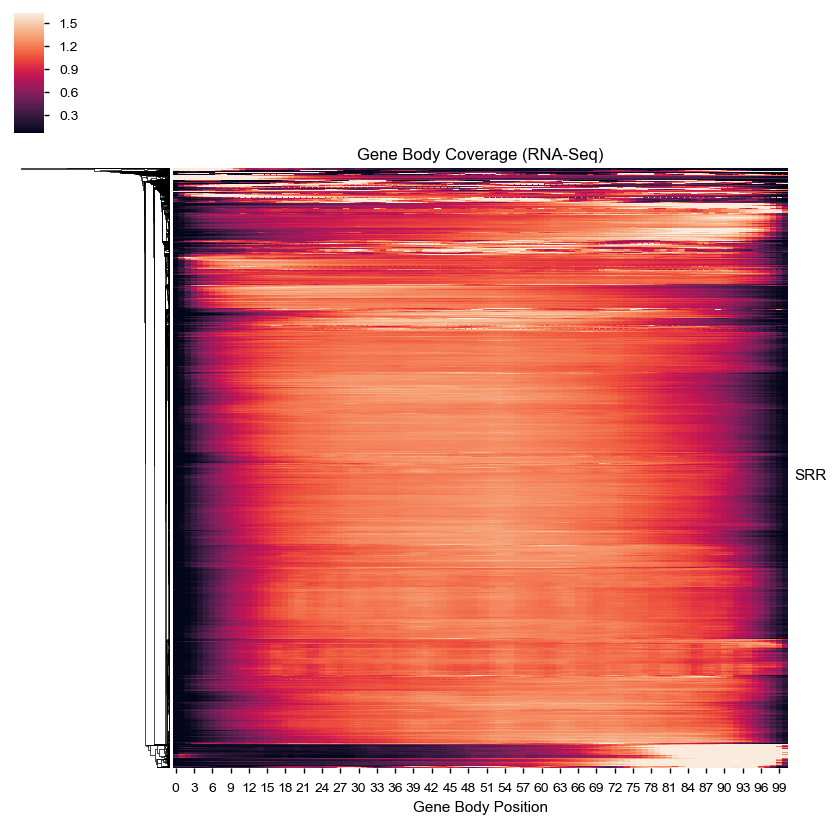

In [53]:
plot_gb('RNA-Seq')

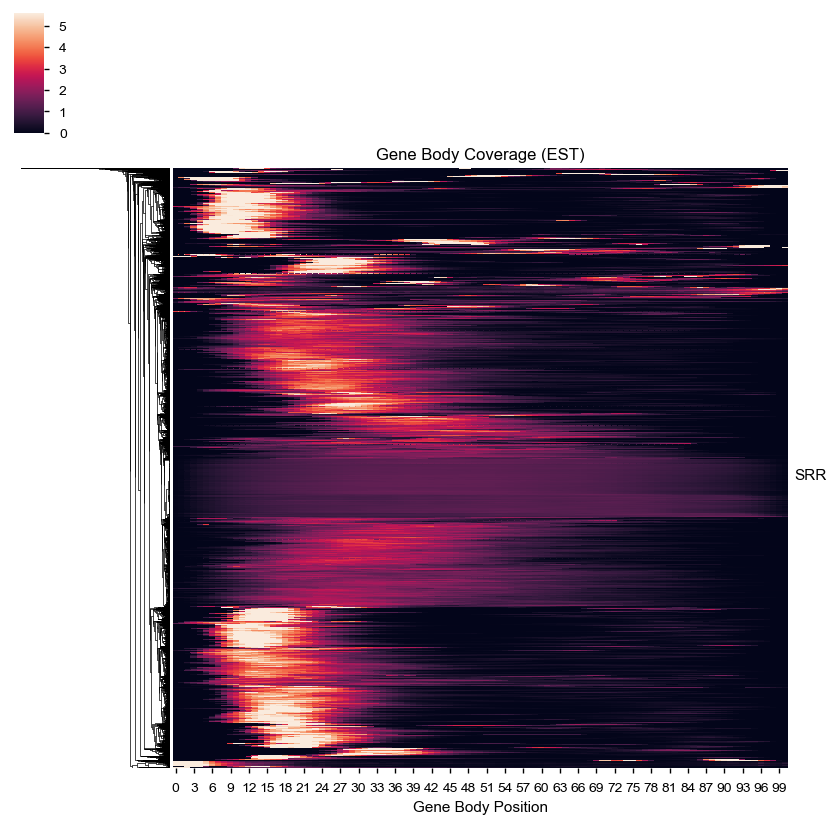

In [54]:
plot_gb('EST')

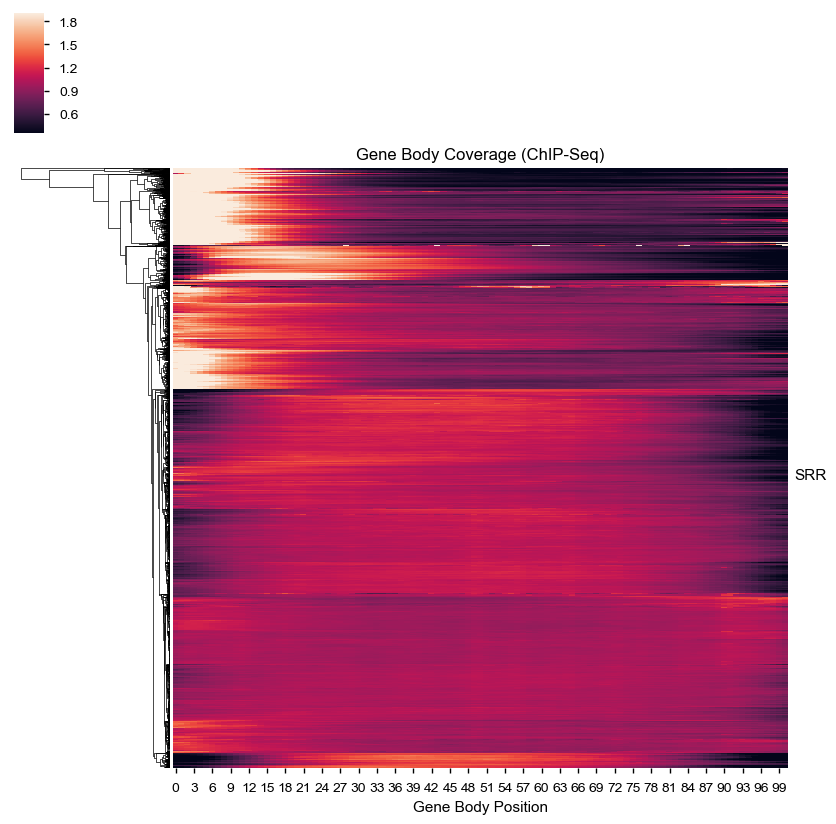

In [55]:
plot_gb('ChIP-Seq')

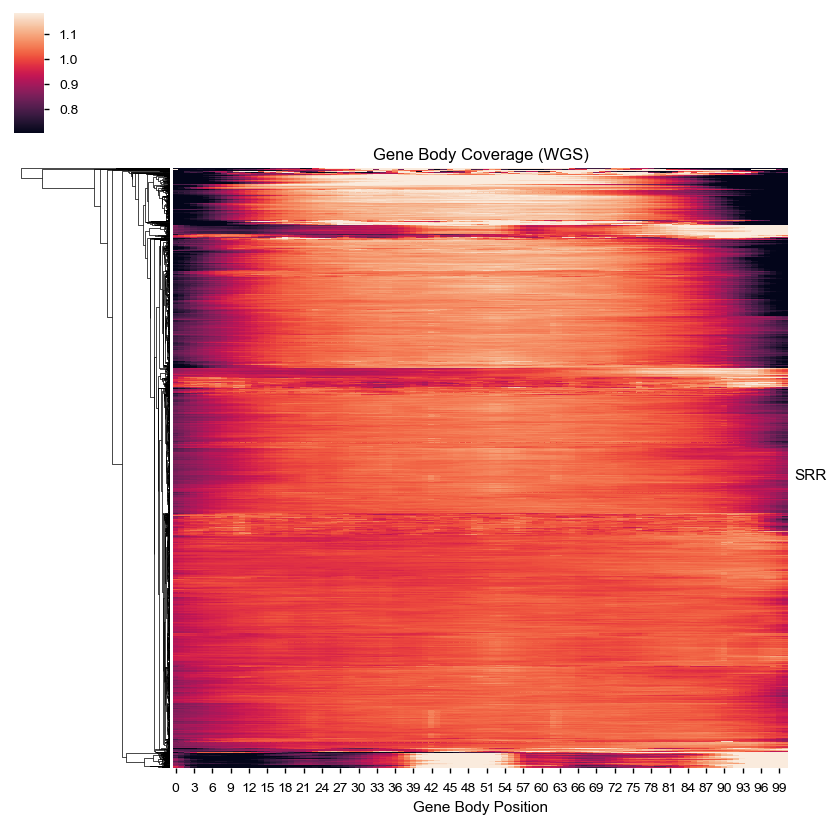

In [56]:
plot_gb('WGS')

In [58]:
target = 'RNA-Seq'
subset = lib_strat.query(f'library_strategy == "{target}"').index.unique().tolist()
cv = store.select('prealn/workflow/collectrnaseqmetrics/genebody', where='srx == subset')

Index(['PF_BASES', 'PF_ALIGNED_BASES', 'RIBOSOMAL_BASES', 'CODING_BASES',
       'UTR_BASES', 'INTRONIC_BASES', 'INTERGENIC_BASES', 'IGNORED_READS',
       'CORRECT_STRAND_READS', 'INCORRECT_STRAND_READS',
       'NUM_R1_TRANSCRIPT_STRAND_READS', 'NUM_R2_TRANSCRIPT_STRAND_READS',
       'NUM_UNEXPLAINED_READS', 'PCT_R1_TRANSCRIPT_STRAND_READS',
       'PCT_R2_TRANSCRIPT_STRAND_READS', 'PCT_RIBOSOMAL_BASES',
       'PCT_CODING_BASES', 'PCT_UTR_BASES', 'PCT_INTRONIC_BASES',
       'PCT_INTERGENIC_BASES', 'PCT_MRNA_BASES', 'PCT_USABLE_BASES',
       'PCT_CORRECT_STRAND_READS', 'MEDIAN_CV_COVERAGE', 'MEDIAN_5PRIME_BIAS',
       'MEDIAN_3PRIME_BIAS', 'MEDIAN_5PRIME_TO_3PRIME_BIAS', 'SAMPLE',
       'LIBRARY', 'READ_GROUP'],
      dtype='object')

In [107]:
subset = lib_strat.query(f'library_strategy == {major_types}').index.unique().tolist()
cv = store.select(
    'prealn/workflow/collectrnaseqmetrics/unstranded', 
    where='srx == subset', 
    columns=['MEDIAN_CV_COVERAGE', 'MEDIAN_5PRIME_BIAS', 'MEDIAN_3PRIME_BIAS', 'MEDIAN_5PRIME_TO_3PRIME_BIAS']
)

cv = cv.join(lib_strat)

Text(0.5,0,'Median CV Coverage')

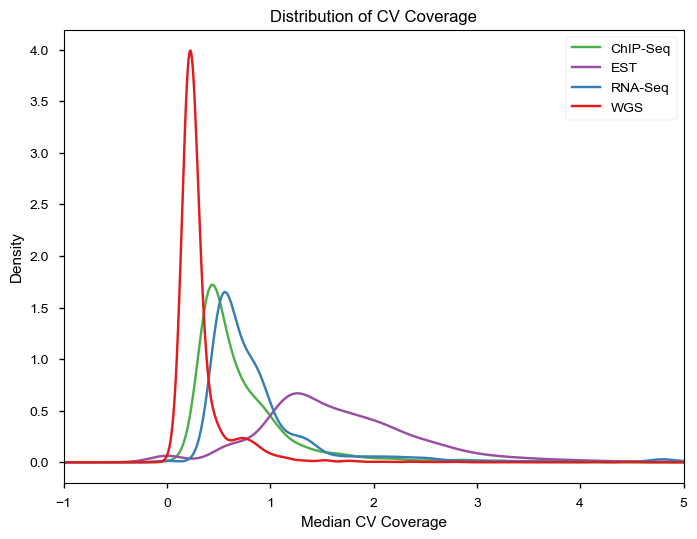

In [108]:
fig, ax = plt.subplots()
cmap = dict(zip(cv.library_strategy.unique(), sns.color_palette(n_colors=5)))
for g, dd in cv.groupby('library_strategy'):
    dd.MEDIAN_CV_COVERAGE.plot.kde(label=g, c=cmap[g], ax=ax)
    
plt.legend()
ax.set_xlim(-1, 5)

ax.set_title('Distribution of CV Coverage')
ax.set_xlabel('Median CV Coverage')

Text(0.5,0,"Median 3' Bias")

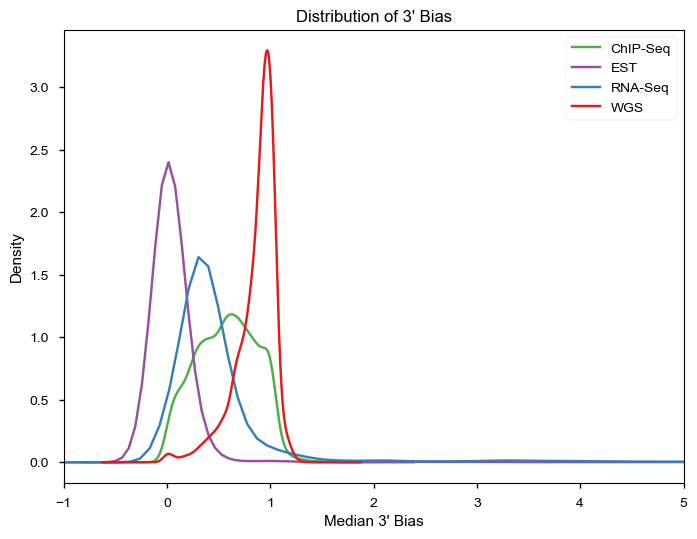

In [109]:
fig, ax = plt.subplots()
cmap = dict(zip(cv.library_strategy.unique(), sns.color_palette(n_colors=5)))
for g, dd in cv.groupby('library_strategy'):
    dd.MEDIAN_3PRIME_BIAS.plot.kde(label=g, c=cmap[g], ax=ax)
    
plt.legend()
ax.set_xlim(-1, 5)

ax.set_title('Distribution of 3\' Bias')
ax.set_xlabel('Median 3\' Bias')

Text(0.5,0,"Median 5' Bias")

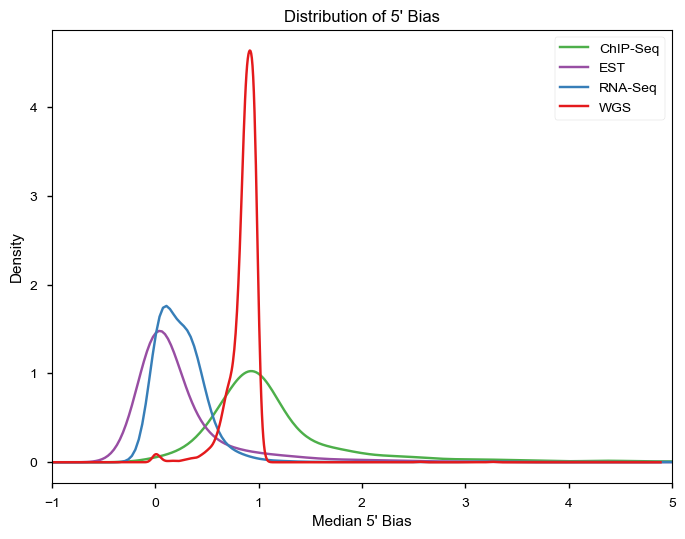

In [110]:
fig, ax = plt.subplots()
cmap = dict(zip(cv.library_strategy.unique(), sns.color_palette(n_colors=5)))
for g, dd in cv.groupby('library_strategy'):
    dd.MEDIAN_5PRIME_BIAS.plot.kde(label=g, c=cmap[g], ax=ax)
    
plt.legend()
ax.set_xlim(-1, 5)

ax.set_title('Distribution of 5\' Bias')
ax.set_xlabel('Median 5\' Bias')

[]

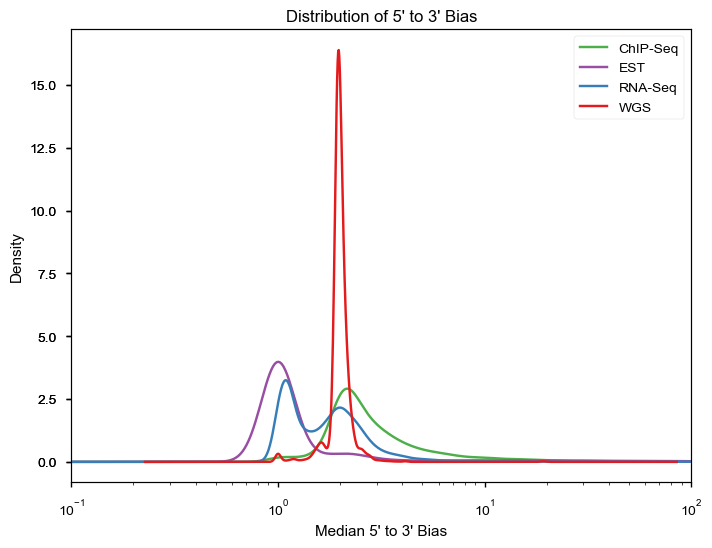

In [131]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax2 = ax.twiny()

cmap = dict(zip(cv.library_strategy.unique(), sns.color_palette(n_colors=5)))
for g, dd in cv.groupby('library_strategy'):
    np.log10(dd.MEDIAN_5PRIME_TO_3PRIME_BIAS + 1).plot.kde(label=g, c=cmap[g], ax=ax2)
    
plt.legend()
ax2.set_xlim(-1, 2)
ax.set_xlim(10**np.array(ax2.get_xlim()))

ax.set_title('Distribution of 5\' to 3\' Bias')
ax.set_xlabel('Median 5\' to 3\' Bias')
ax2.set_xticks([])
ax2.set_xticklabels([])

In [132]:
subset = lib_strat.query(f'library_strategy == {major_types}').index.unique().tolist()

In [32]:
chroms = ['chrX', 'chr2L', 'chr2R', 'chr3L', 'chr3R', 'chrY']

In [156]:
dfs = []
for srx in subset:
    junc = pd.read_parquet(f'../output/aln-wf/junction_counts/{srx}.parquet', columns=['Site1_chr', 'Site2_chr', 'count'])\
        .query(f'Site1_chr == Site2_chr and Site1_chr == {chroms}')
    dfs.append((srx, junc['count'].sum()))

junc = pd.DataFrame(dfs, columns=['srx', 'j_count']).set_index('srx')
junc = junc.join(lib_strat)

In [185]:
junc.j_count = pd.to_numeric(junc.j_count)

In [195]:
num_mapped = store.select('aln/workflow/samtools_stats').reads_mapped

In [208]:
junc = junc.join(num_mapped)

In [210]:
junc['pct_junc'] = junc.j_count / junc.reads_mapped * 100

Text(0.5,0,'Junction Count')

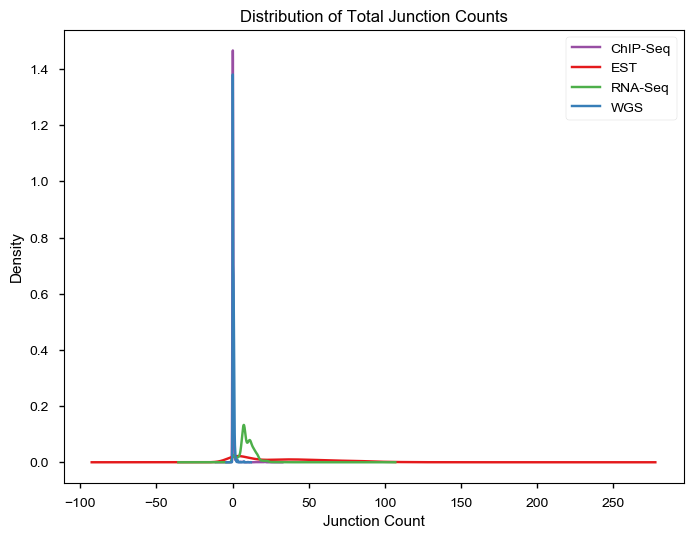

In [204]:
fig, ax = plt.subplots()

cmap = dict(zip(junc.library_strategy.unique(), sns.color_palette(n_colors=5)))
for g, dd in junc.groupby('library_strategy'):
    dd.pct_junc.plot.kde(label=g, c=cmap[g], ax=ax)
    
plt.legend()

ax.set_title('Distribution of Total Junction Counts')
ax.set_xlabel('Junction Count')

In [212]:
junc[(junc.pct_junc > 100)]

,j_count,library_strategy,pct_junc,reads_mapped
srx,,,,
SRX2256359,5031,EST,108.100559,4654
SRX2256398,4430,EST,106.824210,4147
SRX2256426,1740,EST,138.645418,1255
SRX2256458,1450,EST,104.617605,1386
SRX2256498,6452,EST,139.926263,4611
SRX2256503,2900,EST,113.458529,2556
SRX2256535,3298,EST,115.153631,2864
SRX2256562,2720,EST,168.004941,1619
SRX2256710,6019,EST,100.787006,5972


In [9]:
srx = 'SRX2257076'

In [38]:
bob = pd.read_parquet(f'../output/aln-wf/junction_counts/{srx}.parquet', 
               columns=['Site1_chr', 'Site2_chr', 'Site1_location', 'count', 'PrimaryGene']).query(f'Site1_chr == Site2_chr and Site1_chr == {chroms}')

In [39]:
bob

,Site1_chr,Site2_chr,Site1_location,count,PrimaryGene
0,chr2L,chr2L,545306,5,FBgn0005660
1,chr2L,chr2L,5885203,6,FBgn0262814
2,chr2L,chr2L,6682683,1,FBgn0028703
3,chr2L,chr2L,7693307,5,FBgn0262880
4,chr2L,chr2L,7693492,1,FBgn0262880
5,chr2L,chr2L,7821308,1,FBgn0027515
6,chr2L,chr2L,7823100,1,FBgn0027515
7,chr2L,chr2L,15215542,4,FBgn0262875
8,chr2L,chr2L,16844619,1,FBgn0032614
9,chr2L,chr2L,16844801,3,FBgn0032614


In [41]:
pd.read_parquet(f'../output/aln-wf/gene_counts/{srx}.parquet')['count'].sum()

7072

In [28]:
store.select('aln/workflow/samtools_stats', where=f'index == {srx}')

,raw_total_sequences,filtered_sequences,sequences,is_sorted,1st_fragments,last_fragments,reads_mapped,reads_mapped_and_paired,reads_unmapped,reads_properly_paired,...,mismatches,average_length,maximum_length,average_quality,insert_size_average,insert_size_standard_deviation,inward_oriented_pairs,outward_oriented_pairs,pairs_with_other_orientation,pairs_on_different_chromosomes
srx,,,,,,,,,,,,,,,,,,,,,
SRX2257076,7101,0,7101,1,7101,0,7101,0,0,0,...,1899,133.0,135,34.6,0.0,0.0,0,0,0,0


In [30]:
store.select('aln/workflow/hisat2', where=f'srx == {srx}')

,,num_reads,num_reads_paired,num_reads_unpaired,num_concordant_reads_unaligned,num_concordant_reads_uniquely_aligned,num_concordant_multimappers,num_discordant_reads_aligned,num_unaligned,num_uniquely_aligned,num_multimappers,per_alignment
srx,srr,,,,,,,,,,,
SRX2257076,SRR4438268,11230.0,NaN,11230.0,NaN,NaN,NaN,NaN,4120.0,7101.0,9.0,63.31
